# Gradual Pruning
This file is an example of how to use 'pruning.py' and 'model_utils.py'
This uses the CIFAR-10 dataset for its testing

In [1]:
import torch
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
from pytorch_resnet_cifar10 import resnet
import model_utils
import pruning
import time

/home/zache1/anaconda3/envs/pyt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the data

To begin, we need to load the necessary data into a pytorch DataLoader. You can use multiple DataLoaders, as seen below, for training or testing data (you can also include validation data).

When running the below code, the data will be downloaded locally to '/data/CIFAR10'. It should create the folder if it is not there already

In [2]:
# perform the same transform on all the data
transform = tv.transforms.Compose(
    [tv.transforms.ToTensor(), # scale the data between 0..1
     tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize the data

# get the cifar10 data
data_train = tv.datasets.CIFAR10(root="data/CIFAR10/train", train=True, download=True, transform=transform)
data_test = tv.datasets.CIFAR10(root="data/CIFAR10/test", train=False, download=True, transform=transform)

# create the dataloaders for each dataset. These will be used for training and getting accuracy of a model
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=False)
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size=128, shuffle=False)

print(np.shape(data_test.data))

Files already downloaded and verified
Files already downloaded and verified
(10000, 32, 32, 3)


# Creating Models

The below code creates four pytorch models, sends them to the gpu if available, prepares them using 'prepare_model'
The models are pretrained and are obtained from the 'pytorch_resnet_cifar10' library that should be cloned in as well

In [3]:
# get the device, being gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# these models will be ordered from most to least gradual
models = []

for _ in range(4):
    # Create the model from pytorch_resnet_cifar10
    model = resnet.resnet56()

    # load the model with the correct weights
    # must use DataParallel since the data was saved as a DataParallel
    torch.nn.DataParallel(model).load_state_dict(torch.load('pytorch_resnet_cifar10/pretrained_models/resnet56-4bfd9763.th', map_location=device)['state_dict'])

    # send the model to the gpu
    model.to(device)

    # prepare the model
    model_utils.prepare_model(model)    

    models.append(model)

# The Training Function

This function will be used to train the model.<br>
This uses L2 regularization with regularization value specified as 'weight_decay' in the initialization of 'optimizer'

In [4]:
def train(model, epochs, dataloader):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.0001)

    for i in range(epochs):
        for (images, labels) in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        print("\t\tEpoch: {}".format(i))

# Gradual Pruning

We will now apply gradual pruning. Since pruning scales multiplicatively (pruning a model 90% that is already pruned 90% will result in the model being pruned 90% * 90% = 81%), if we have a target pruning percentage, then we will need to determine how much we need to prune for each iteration. The formula for calculating how much to prune for every pruning is as follows:

Let $t$ be the number of prunes<br>
Let $P$ be the target prune percentage<br>
$$1-\sqrt[t]{1-P}$$

Gradual Pruning: Prune 8 times
<br>120 epochs total => 15 epochs after each prune
<br>Target prune: 90% => 25.01% pruning per prune

Gradual Pruning: Prune 4 times
<br>120 epochs total => 30 epochs after each prune
<br>Target prune: 90% => 43.77% pruning per prune

Gradual Pruning: Prune 2 times
<br>120 epochs total => 60 epochs after each prune
<br>Target prune: 90% => 68.38% pruning per prune

Gradual Pruning: Prune 1 time
<br>120 epochs total => 120 epochs after each prune
<br>Target prune: 90% => 90% pruning per prune

In [5]:
times_pruned = np.array([8, 4, 2, 1])
epochs_per_prune = np.array([15, 30, 60, 120])
# epochs_per_prune = np.array([1, 2, 4, 8])
prune_percentage_per_prune = np.array([0.2501, 0.4377, 0.6838, 0.9]) # these values are obtained from the above formula
accuracies = []
prune_percentages = []
times = []

for i, prune_times in enumerate(times_pruned):
    # tracking times
    start_time = time.perf_counter()
    # the accuracy after each prune and train
    accuracy = np.zeros(prune_times)
    # the percentage of the original model that is actually pruned
    prune_percentage = np.zeros(prune_times)
    for prune in range(prune_times):
        # print a message to know how close the program is finishing
        print("Times to prune: {}\n\tTimes pruned: {}".format(prune_times, prune))
        # apply the global mag weight prune on the model
        pruning.global_mag_weight_prune(models[i], prune_percentage_per_prune[i])
        # train the model
        train(models[i], epochs_per_prune[i], dataloader_train)
        # obtain the accuracy of the model so far. The accuracy is tested on the test dataset. 
        # This information is not used for training, to there is no overfitting of the data
        accuracy[prune] = model_utils.get_accuracy(models[i], dataloader_test, device)
        # calculate how much of the model is actually pruned
        prune_percentage[prune] = model_utils.pruned_percentage(models[i], 'weight')
    end_time = time.perf_counter()
    accuracies.append(accuracy)
    prune_percentages.append(prune_percentage)
    times.append(end_time - start_time)

Times to prune: 8
	Times pruned: 0
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
Times to prune: 8
	Times pruned: 1
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
Times to prune: 8
	Times pruned: 2
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
Times to prune: 8
	Times pruned: 3
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12
		Epoch: 13
		Epoch: 14
Times to prune: 8
	Times pruned: 4
		Epoch: 0
		Epoch: 1
		Epoch: 2
		Epoch: 3
		Epoch: 4
		Epoch: 5
		Epoch: 6
		Epoch: 7
		Epoch: 8
		Epoch: 9
		Epoch: 10
		Epoch: 11
		Epoch: 12

# Plotting Data

The below code simply plots the data obtained

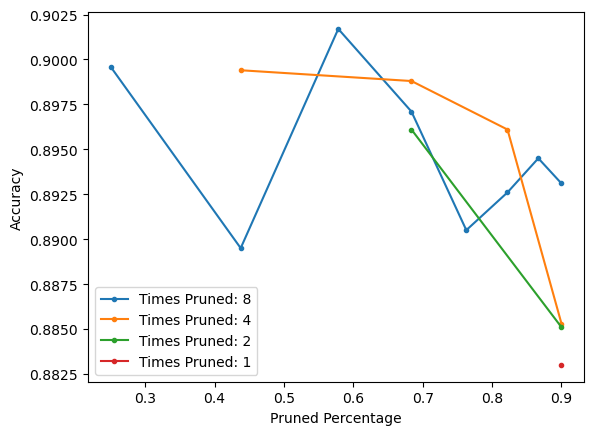

In [6]:
fig, axis = plt.subplots()

for i, prunes in enumerate(times_pruned):
    axis.plot(prune_percentages[i], accuracies[i], ".-", label="Times Pruned: {}".format(prunes))
    axis.legend()
    axis.set_ylabel("Accuracy")
    axis.set_xlabel("Pruned Percentage")

In [7]:
accuracies

[array([0.8996, 0.8895, 0.9017, 0.8971, 0.8905, 0.8926, 0.8945, 0.8931]),
 array([0.8994, 0.8988, 0.8961, 0.8853]),
 array([0.8961, 0.8851]),
 array([0.883])]

In [8]:
prune_percentages

[array([0.25009989, 0.43765042, 0.57829481, 0.68376311, 0.76285465,
        0.82216537, 0.86664254, 0.899996  ]),
 array([0.43769977, 0.68381835, 0.8222112 , 0.90002891]),
 array([0.68379954, 0.90001716]),
 array([0.89999953])]

In [9]:
times

[3957.9136946201324, 3938.5677162110806, 3937.929022628814, 3936.303681191057]